## Use the right version of Tensorflow


In [0]:
%tensorflow_version 2.x

## Call the important statements

The following code imports the necessary code to run the code in the rest of this Colaboratory.

In [47]:
#@title Call the import statements

import numpy as np
import pandas as pd 
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import re,string,unicodedata
from string import punctuation

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from os import path

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt


from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import  Dense, Activation, Dropout,Bidirectional, GlobalMaxPool1D,BatchNormalization, Embedding,LSTM, Flatten


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#@title Load Stopwords, Stemmer, and Lemmatizer

sw = stopwords.words('english')
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer() 

## define the replace_puncts, strip_chars, and puncts

this list and arrays are going to be used in defining the functions

In [0]:
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = list(string.punctuation)

## Define functions that clean, lemmatize, process text, and remove stem words from text

The following code defines three functions:

  * `clean_text`, which convert word to lower case and replace some characters
  * `stem`, steam each word in the given text
  * `lemm`, which will lemmatize word
  * `stopwords1`, which remove the stopwords

In [0]:
#@title Define functions that stem, lemmatize, process text, and remove stem words

def clean_text(x):
    x = str(x)
    x = x.lower()
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
   
    return x

def stopwords1(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)


def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

def lemm(text):    
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text) 


## define text_processing function

this `text_processing(text)` function incorporate all the function above into one function that will be used to process `text` later

In [0]:
def text_processing(X):
    X=X.apply(stopwords1)
    X=X.apply(clean_text)
    X=X.apply(stemming)
    X=X.apply(lemm)
    return X

## Loading Dataset

in this project, we use data from Kaggle :  [Fake and Real News Dasaset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) 


In [0]:
fake_dataset_url = 'https://raw.githubusercontent.com/Bangkit-2-Jakarta-Team/Fake-News-Detection/master/Datasets/Fake.csv'
true_dataset_url='https://raw.githubusercontent.com/Bangkit-2-Jakarta-Team/Fake-News-Detection/master/Datasets/True.csv'

df_fake = pd.read_csv(fake_dataset_url)
df_true = pd.read_csv(true_dataset_url)
df_fake['is_true'] = 0
df_true['is_true'] = 1

# make length of true and fake dataset same
length_df = min(len(df_fake), len(df_true))
df_fake = df_fake[:length_df]
df_true = df_true[:length_df]

#fake_title = df_fake['title']
true_title = df_true['title']

In [0]:
#Merge two dataframe into one
df_data = pd.concat([df_fake,df_true])

In [54]:
#Showing sample
df_data.sample(5)

,title,text,subject,date,is_true
4184,"As Trump warned North Korea, his 'armada' was ...",WASHINGTON (Reuters) - When U.S. President Do...,politicsNews,"April 19, 2017",1
19926,GRAB THE POPCORN! Queen Of Corruption DENIED S...,The Drudge Report has gained access to the rul...,left-news,"Sep 24, 2016",0
15610,Trump greets Japanese emperor with a handshake...,TOKYO (Reuters) - U.S. President Donald Trump ...,worldnews,"November 6, 2017",1
20387,PARANOID OR SMART? WHAT FACEBOOK’S CEO Does To...,Facebook CEO Mark Zuckerberg appears to be con...,left-news,"Jun 21, 2016",0
4931,"Apple, Google, Facebook skip legal challenge t...","SAN FRANCISCO (Reuters) - Apple Inc, Alphabet ...",politicsNews,"March 16, 2017",1


In [0]:
#Randomizing data sequence to scatter data
df_data = shuffle(df_data).reset_index(drop=True)

In [0]:
x = df_data['title']
y = df_data['is_true']

In [0]:
#Clean data using text_processing() function
clean_x = text_processing(x)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [0]:
y_test_temp = y_test
max_words = 3000
tokenize = text.Tokenizer(num_words=max_words)
#tokenize.fit_on_texts(x_train) # only fit on train
x_train = tokenize.texts_to_sequences(x_train)
x_test = tokenize.texts_to_sequences(x_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

## Generating Wordcloud that show most common word in News Title

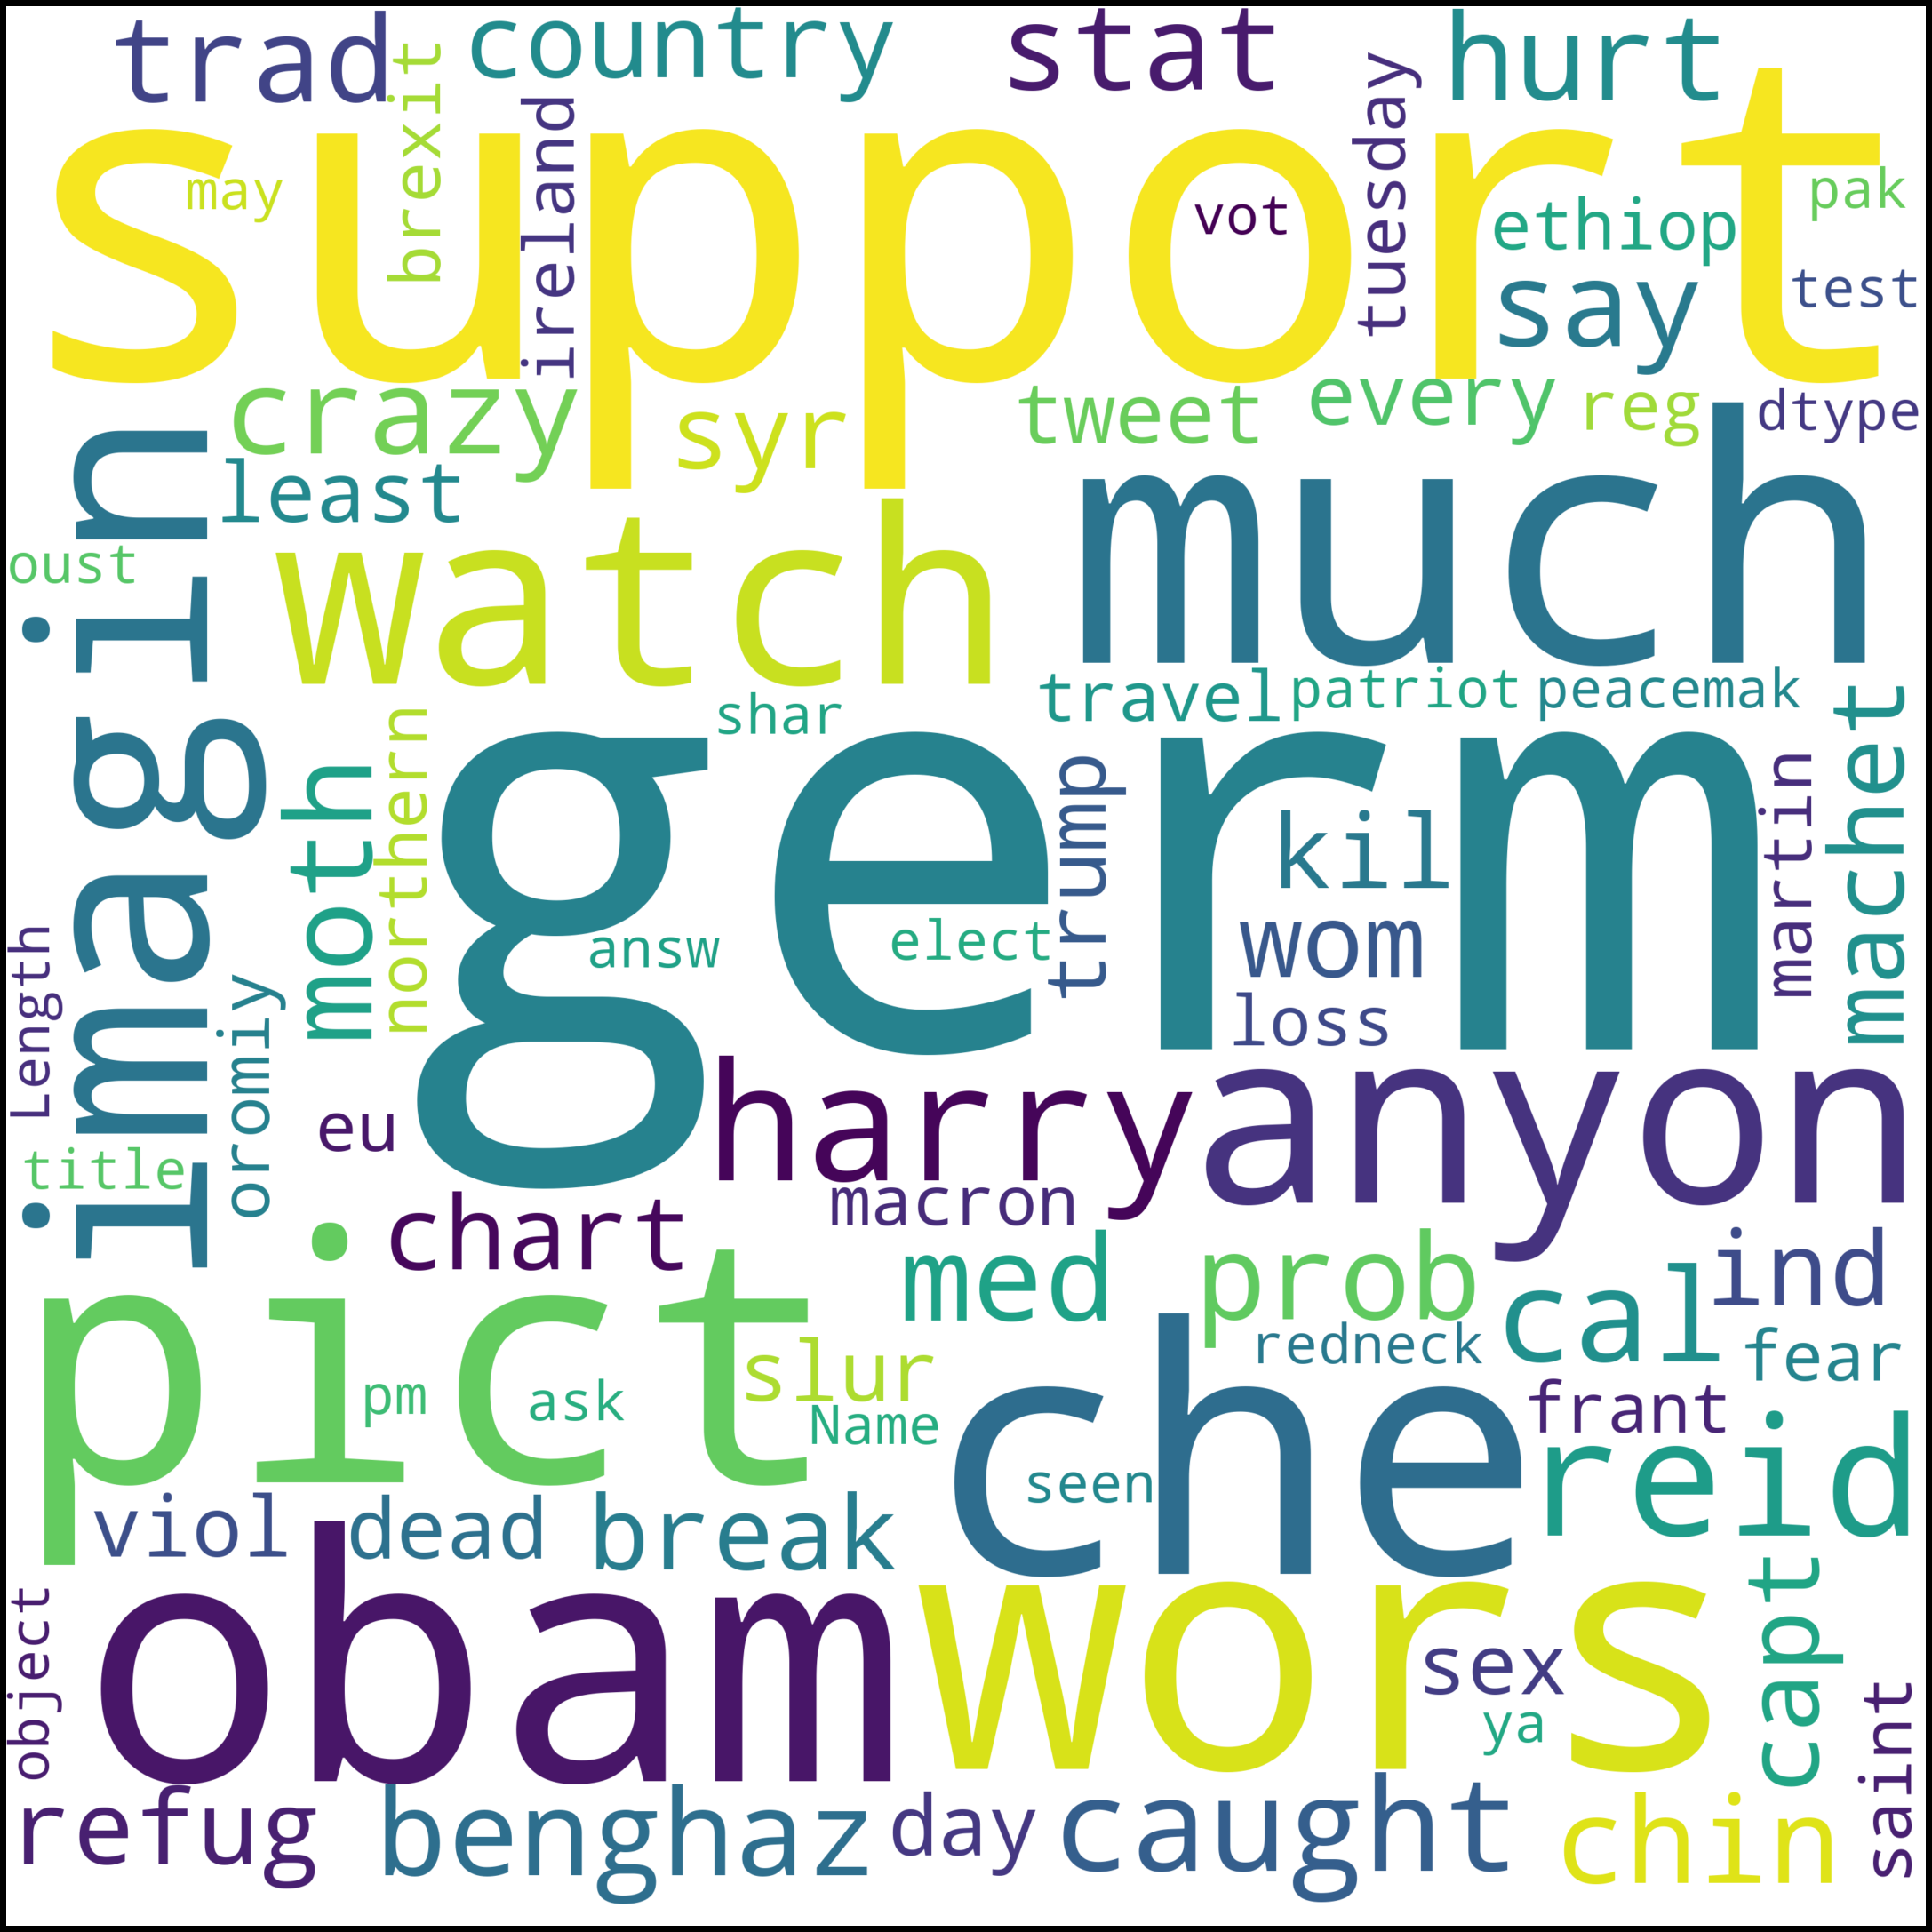

In [56]:
#Counting Unique word to generate WordCloud
text = clean_x
wordcloud= WordCloud(
    width =3000,
    height = 3000,
    background_color='white',
    stopwords=STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40,30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [0]:
max_sequences= 300
x_train=pad_sequences(x_train,maxlen=max_sequences)
x_test=pad_sequences(x_test,maxlen=max_sequences)

In [0]:
#LSTM DTS
embed_size = 128

model = Sequential()
model.add(Embedding(max_words,embed_size,input_length=max_sequences))
model.add(Bidirectional((LSTM(64,return_sequences = True,recurrent_dropout=0.5))))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(GlobalMaxPool1D())
model.add(Dense(48, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(len(y.unique()), activation="softmax"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [18]:
 batch_size = 64
epochs = 10

#callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),]
    
history3 =model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          validation_split=0.2)

Epoch 1/10
393/393 [==============================] - 412s 1s/step - loss: 0.6964 - accuracy: 0.5229 - val_loss: 0.6942 - val_accuracy: 0.4885
Epoch 2/10
393/393 [==============================] - 410s 1s/step - loss: 0.6917 - accuracy: 0.5288 - val_loss: 0.6941 - val_accuracy: 0.5115
Epoch 3/10
393/393 [==============================] - 410s 1s/step - loss: 0.6915 - accuracy: 0.5288 - val_loss: 0.6961 - val_accuracy: 0.5115
Epoch 4/10
393/393 [==============================] - 412s 1s/step - loss: 0.6916 - accuracy: 0.5288 - val_loss: 0.6956 - val_accuracy: 0.5115
Epoch 5/10
393/393 [==============================] - 420s 1s/step - loss: 0.6915 - accuracy: 0.5288 - val_loss: 0.6960 - val_accuracy: 0.5115
Epoch 6/10
393/393 [==============================] - 416s 1s/step - loss: 0.6915 - accuracy: 0.5288 - val_loss: 0.6973 - val_accuracy: 0.5115
Epoch 7/10
393/393 [==============================] - 421s 1s/step - loss: 0.6915 - accuracy: 0.5288 - val_loss: 0.6980 - val_accuracy: 0.5115

In [19]:
accr1 = model.evaluate(x_test,y_test)

421/421 [==============================] - 42s 100ms/step - loss: 0.6956 - accuracy: 0.5174


In [20]:
print('AKURASI DARI LSTM \nTest set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

AKURASI DARI LSTM 
Test set
  Loss: 0.696
  Accuracy: 0.517
